# Plot 1-dimensional output plots
This notebook plots each parameter against the outputs that we are interested in.  
First, all together to asses the correlation between parameters and outputs.  
Then, we plot the two key factors against transition time and split by mean RWP.

## Imports, fonts, functions

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import scipy.stats

In [2]:
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 15

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)    # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=MEDIUM_SIZE)  # fontsize of the figure title


In [3]:
def load_output(design_name, output_name):
    return np.loadtxt(f"/home/users/eers/sct/old_repo/output_data/sct_{design_name}_{output_name}.csv", delimiter=',')

def plot_output(inputs, output, ax_row, c, marker=None, ylabel=None, cmap=None, norm=None):
    if marker is not None:
        marker=marker
    else:
        marker='o'
    
    for i in range(6):
        ax_row[i].scatter(inputs[:,i], output, c=c, s=80, marker=marker, cmap=cmap, norm=norm)
        x_data = inputs[:,i]
        y_data = output
        
        r, y_mean, x_mean, y_std, x_std = calc_r(x_data, y_data)
        m, b = calc_line(r, y_mean, x_mean, y_std, x_std)
        x_data_sorted = np.sort(x_data)
            
        y_pred = [(m*x+b) for x in x_data_sorted]

        corr = scipy.stats.pearsonr(x_data, y_data)  
        ax_row[i].plot(x_data_sorted, y_pred, c='black', lw=2, label=f'r: {corr.correlation:.2f}, p: {corr.pvalue:.3f}')
        ax_row[i].text(0, -0.25, f'r: {corr.correlation:.2f}', transform= ax_row[i].transAxes)
        ax_row[i].text(0, -0.35, f'p: {corr.pvalue:.3f}', transform= ax_row[i].transAxes)
    
    ax_row[0].set_ylabel(ylabel)
    return m
    
def add_titles(axes):
    titles = [r'$BL~q_{v}$', r'$Inv$', r'$\Delta~\theta$', r'$\Delta~q_{v}$', r'$N_{a}$', r'$b_{aut}$', 'vs transition time']
    for ax, title in zip(axes[0], titles):
        ax.set_title(title)
        
def calc_mean_std(dataset):
    mean = np.sum(dataset)/len(dataset)
    std = (np.sum([(i - mean)**2 for i in dataset])/(len(dataset)-1))**0.5
    std_val = [(i - mean)/std for i in dataset]
    return mean, std, std_val

def calc_r(x_data, y_data):
    '''
    Calculates the correlation coefficient r, which is essentially the mean of the standardised residuals
    '''
    x_mean, x_std, x_std_val = calc_mean_std(x_data)
    y_mean, y_std, y_std_val = calc_mean_std(y_data)
    
    product = [z_x*z_y for z_x, z_y in zip(x_std_val, y_std_val)]
    
    return np.sum(product)/(len(x_data) - 1), y_mean, x_mean, y_std, x_std

def calc_line(r, y_mean, x_mean, y_std, x_std):
    m = r*(y_std/x_std)
    b = y_mean - m*x_mean
    return m, b

In [4]:
SMALL_SIZE = 18
MEDIUM_SIZE = 22
BIGGER_SIZE = 15

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

blue_colour = "#2d93adff"
red_colour = "#c83737ff"

def plot_1d_keys(output_data, inputs):
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,5), sharey='row', dpi=300)    # just delta theta and na
    plt.subplots_adjust(top=0.75, bottom=0.2, wspace=0.425, left=0.1, right=0.86)
    
    titles = [r'$\Delta\theta$',r'$\mathrm{BL}\,\mathit{N}_{\mathrm{a}}$']
    slopes = []
    for l, (title, i, letter) in enumerate(zip(titles, [2,4], ["(a)", "(b)"])):
        axes[l].set_xlabel(title)
    
        axes[l].scatter(inputs[:,i][output_data["RWP mean"] > 7], output_data["Transition time"][output_data["RWP mean"] > 7], c=blue_colour, s=80, marker='o')
        axes[l].scatter(inputs[:,i][output_data["RWP mean"] < 7], output_data["Transition time"][output_data["RWP mean"] < 7], c=red_colour, s=80, marker='v')

        # Low RWP
        x_data = inputs[:,i][output_data["RWP mean"] < 7]
        y_data = output_data["Transition time"][output_data["RWP mean"] < 7]

        coef = np.polyfit(x_data, y_data, 1)
        poly1d_fn = np.poly1d(coef)

        norm_coef = np.polyfit(x_data, y_data/np.mean(y_data), 1)
        slopes.append(norm_coef[0])
        pearson = scipy.stats.pearsonr(x_data, y_data)
        
        axes[l].plot(x_data, poly1d_fn(x_data), c=red_colour, lw=2, label=f'r: {pearson.correlation:.2f}')
        axes[l].text(1.05, 0.9, f'r: {pearson.correlation:.2f}', transform= axes[l].transAxes, color=red_colour)
        axes[l].text(1.05, 0.8, f'p: {pearson.pvalue:.2f}', transform= axes[l].transAxes, color=red_colour)

        # High RWP
        x_data = inputs[:,i][output_data["RWP mean"] > 7]
        y_data = output_data["Transition time"][output_data["RWP mean"] > 7]

        coef = np.polyfit(x_data, y_data, 1)
        poly1d_fn = np.poly1d(coef)

        norm_coef = np.polyfit(x_data, y_data/np.mean(y_data), 1)
        slopes.append(norm_coef[0])
        pearson = scipy.stats.pearsonr(x_data, y_data)
        
        axes[l].plot(x_data, poly1d_fn(x_data), c=blue_colour, lw=2, label=f'r: {pearson.correlation:.2f}')
        axes[l].text(1.05, 0.7, f'r: {pearson.correlation:.2f}', transform= axes[l].transAxes, color=blue_colour)
        axes[l].text(1.05, 0.6, f'p: {pearson.pvalue:.2f}', transform= axes[l].transAxes, color=blue_colour)

        # All
        x_data = inputs[:,i]
        y_data = output_data["Transition time"]

        coef = np.polyfit(x_data, y_data, 1)
        poly1d_fn = np.poly1d(coef)
        
        norm_coef = np.polyfit(x_data, y_data/np.mean(y_data), 1)
        slopes.append(norm_coef[0])

        pearson = scipy.stats.pearsonr(x_data, y_data)
    
        axes[l].plot(x_data, poly1d_fn(x_data), c='black', lw=2, label=f'r: {pearson.correlation:.2f}')
        axes[l].text(1.05, 0.5,f'r: {pearson.correlation:.2f}',transform=axes[l].transAxes,fontsize=SMALL_SIZE) #0.67
        axes[l].text(1.05, 0.4,f'p: {pearson.pvalue:.2f}',transform=axes[l].transAxes,fontsize=SMALL_SIZE) #0.67
        
        axes[l].text(0.03, 0.9,f'{letter}',transform=axes[l].transAxes,fontsize=SMALL_SIZE)
    
    
    x_data = output_data["RWP mean"]
    y_data = output_data["Transition time"]
    axes[-1].scatter(x_data, y_data, c='black', s=80)
    coef = np.polyfit(x_data, y_data, 1)
    poly1d_fn = np.poly1d(coef)
    
    norm_coef = np.polyfit(x_data, y_data/np.mean(y_data), 1)
    slopes.append(norm_coef[0])

    corr = scipy.stats.pearsonr(x_data, y_data)  

    axes[-1].plot(x_data, poly1d_fn(x_data), c='black', lw=2, label=f'r: {pearson.correlation:.2f}')
    axes[-1].text(1.05, 0.9,f'r: {corr.correlation:.2f}',transform=axes[-1].transAxes, fontsize=SMALL_SIZE)
    axes[-1].text(1.05, 0.8,f'p: {corr.pvalue:.2f}',transform=axes[-1].transAxes, fontsize=SMALL_SIZE)
    axes[-1].text(0.03, 0.9,'(c)',transform=axes[-1].transAxes,fontsize=SMALL_SIZE) #0.67
    
    axes[-1].set_xlabel(r"Mean $\mathit{R}$ (g m$^{-2}$)")
    axes[0].set_ylabel("Transition time (h)")
    
    blues = mlines.Line2D([], [], color=blue_colour, marker='o', linestyle='None',
                              markersize=10)
    reds = mlines.Line2D([], [], color=red_colour, marker='v', linestyle='None',
                              markersize=10)
    fig.legend(handles=[reds, blues], 
                 labels=[r"Mean $\mathit{R}$ < 7 g m$^{-2}$", r"Mean $\mathit{R}$ > 7 g m$^{-2}$"], 
                 loc=(0.06,0.78), frameon=False)
    return fig, slopes

## Plot all parameters against outputs of interest

### Post spinup

In [25]:
output_data = {}
output_data["RWP mean"] = np.loadtxt("data/output_data/rwp_mean_output.csv", delimiter=',', skiprows=1)
output_data["Transition time"] = np.loadtxt("data/output_data/transition_time_output.csv", delimiter=',', skiprows=1)

inputs = np.loadtxt("data/input_data/post_spinup_inputs.csv", delimiter=',', skiprows=1)
inputs[:,5] = [10**x for x in inputs[:,5]]

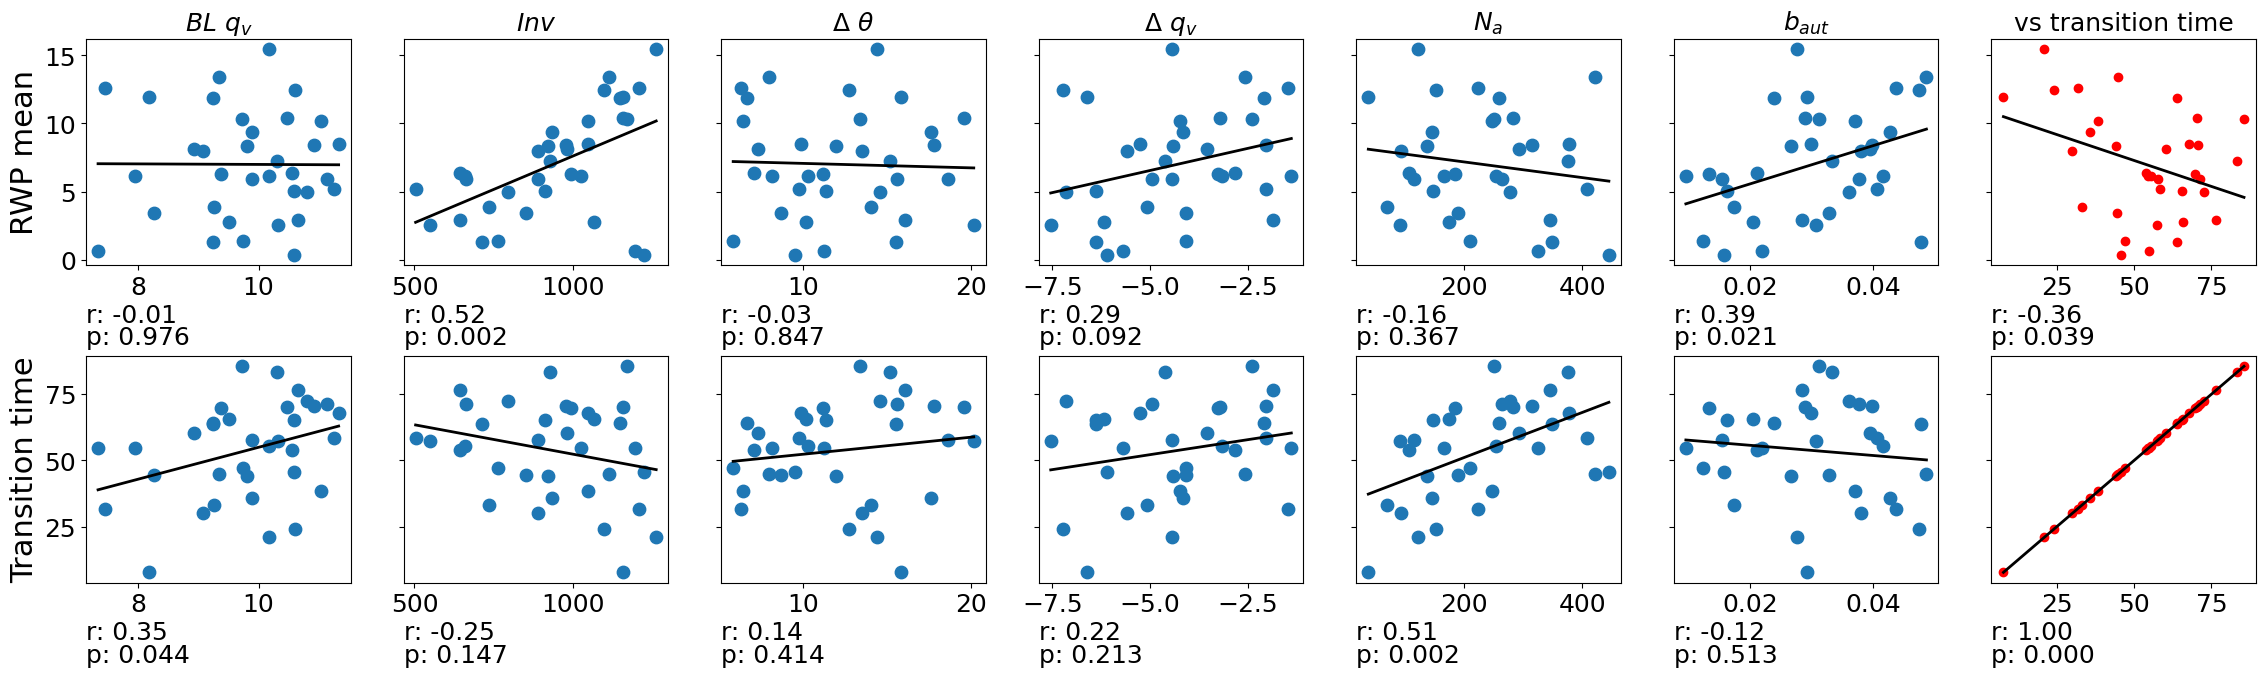

In [26]:
### Indicators

r = len(output_data.keys())
c = 7
fig, axes = plt.subplots(nrows=r, ncols=c, figsize=(4*c,4*r), sharey='row')
plt.subplots_adjust(hspace=0.4, bottom=0.2)

for ax_row, (name, output) in zip(axes, output_data.items()):      
    plot_output(inputs, output, ax_row, "C0", ylabel=name)
    
    ax_row[-1].scatter(output_data["Transition time"], output, c='red')
    x_data = output_data["Transition time"]
    y_data = output
    r, y_mean, x_mean, y_std, x_std = calc_r(x_data, y_data)
    m, b = calc_line(r, y_mean, x_mean, y_std, x_std)
    x_data_sorted = np.sort(x_data)
    y_pred = [(m*x+b) for x in x_data_sorted]

    corr = scipy.stats.pearsonr(x_data, y_data)  
    ax_row[-1].plot(x_data_sorted, y_pred, c='black', lw=2, label=f'r: {corr.correlation:.2f}, p: {corr.pvalue:.2f}')
    ax_row[-1].text(0, -0.25, f'r: {corr.correlation:.2f}', transform= ax_row[-1].transAxes)
    ax_row[-1].text(0, -0.35, f'p: {corr.pvalue:.3f}', transform= ax_row[-1].transAxes)

add_titles(axes)

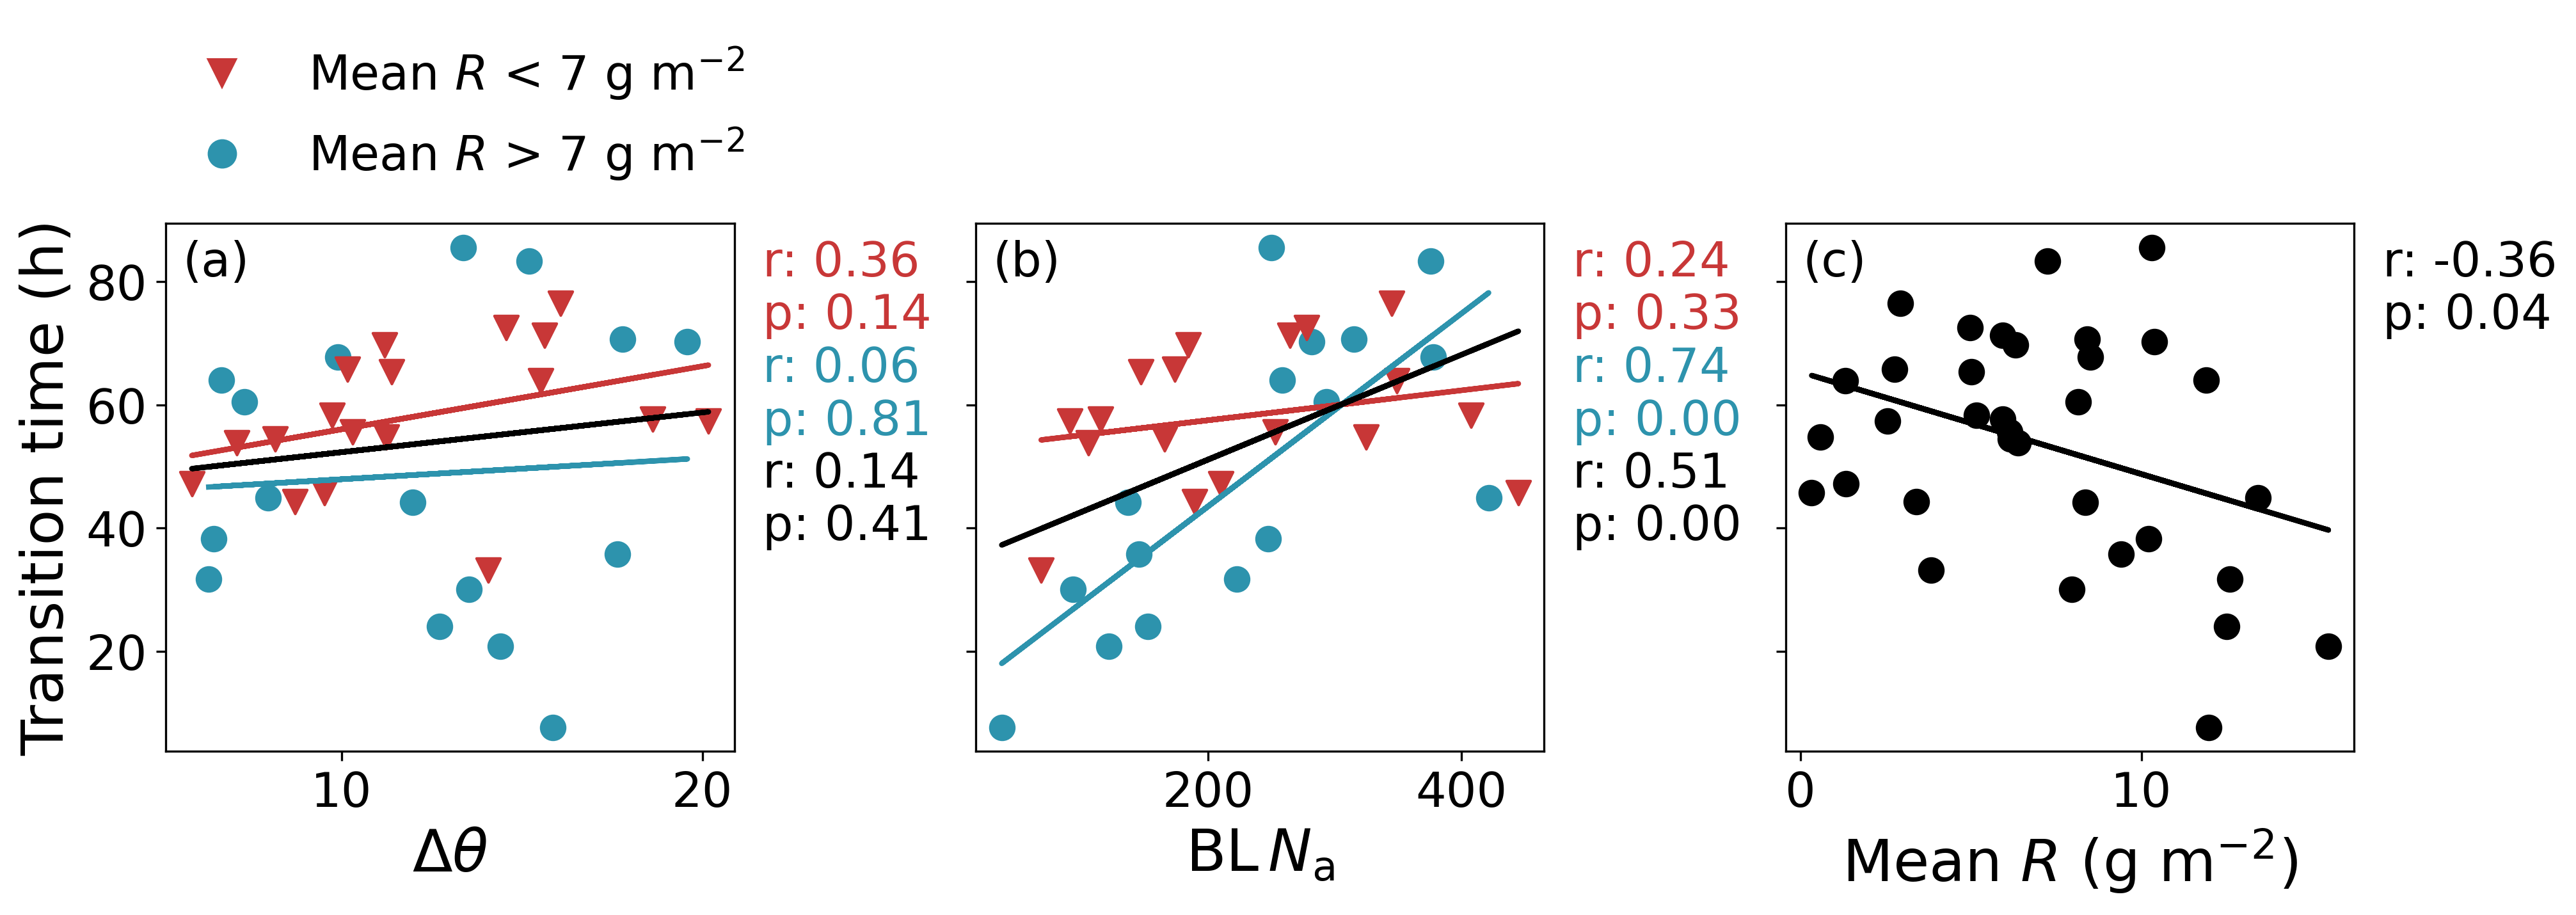

In [27]:
fig, slopes = plot_1d_keys(output_data, inputs)
plt.show()

### Sc beginning time, cu thresh = 0.55, SST thresh = 296 K

In [28]:
output_data = {}
output_data["RWP mean"] = np.loadtxt("data/output_data/rwp_mean_output.csv", delimiter=',', skiprows=1)
output_data["Transition time"] = np.loadtxt("data/output_data/transition_time_output.csv", delimiter=',', skiprows=1)

inputs = np.loadtxt("data/input_data/sc_beginning_inputs.csv", delimiter=',', skiprows=1)
inputs[:,5] = [10**x for x in inputs[:,5]]

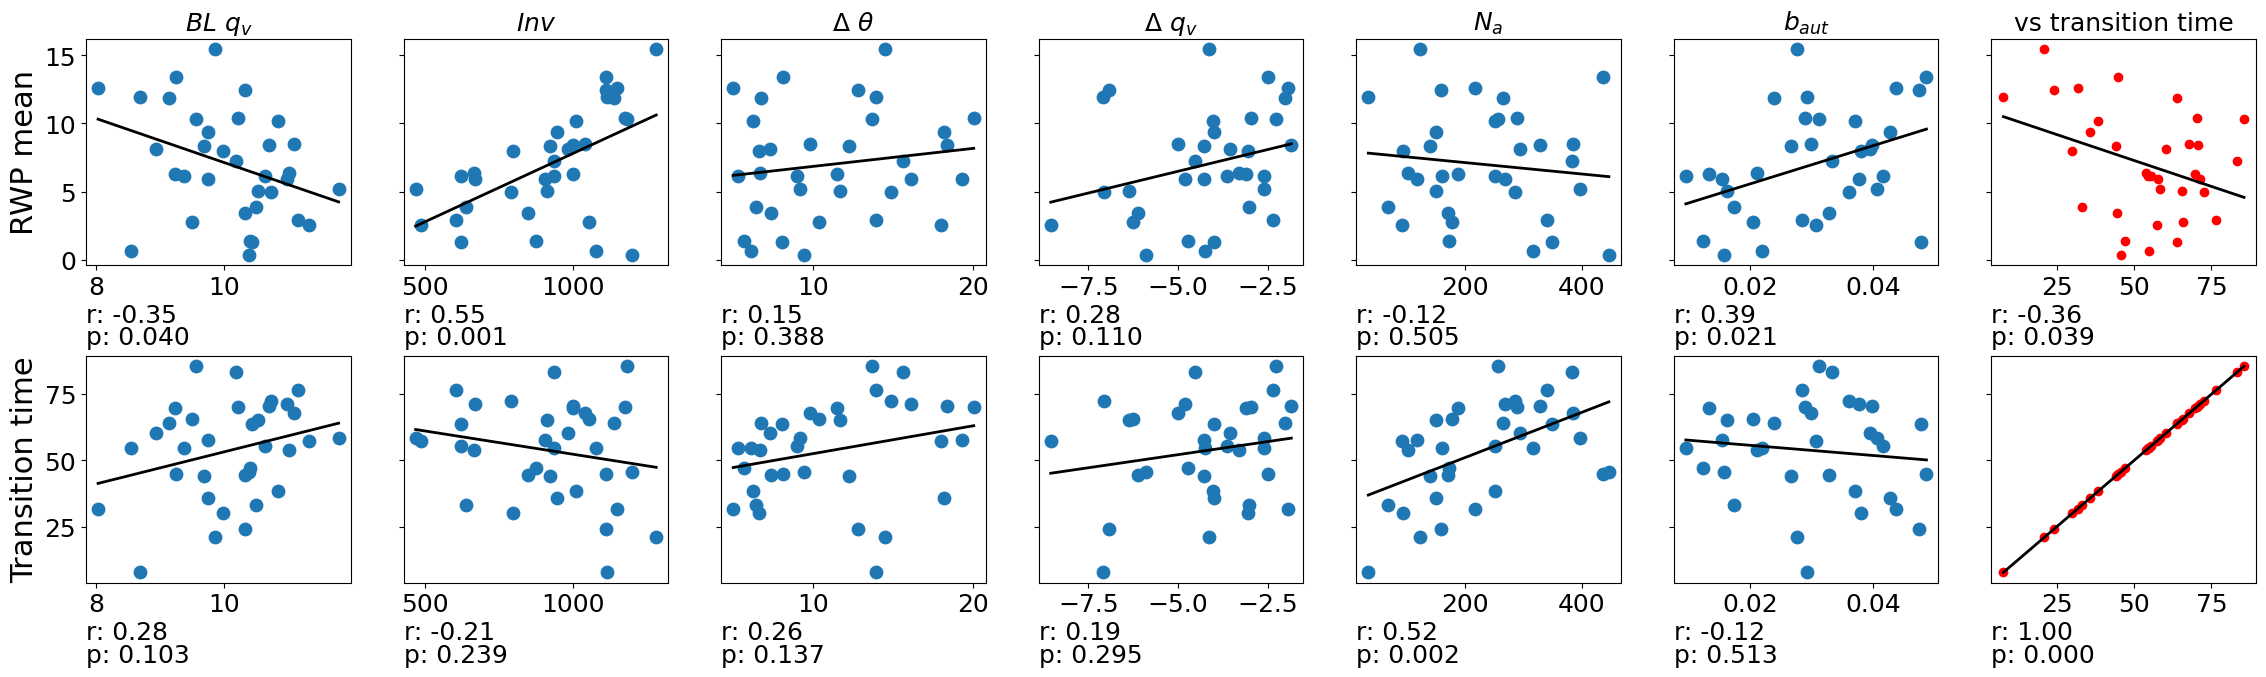

In [29]:
### Big grid of possible indicators

r = len(output_data.keys())
c = 7
fig, axes = plt.subplots(nrows=r, ncols=c, figsize=(4*c,4*r), sharey='row')
plt.subplots_adjust(hspace=0.4, bottom=0.2)

for ax_row, (name, output) in zip(axes, output_data.items()):      
    plot_output(inputs, output, ax_row, "C0", ylabel=name)
    
    ax_row[-1].scatter(output_data["Transition time"], output, c='red')
    x_data = output_data["Transition time"]
    y_data = output
    r, y_mean, x_mean, y_std, x_std = calc_r(x_data, y_data)
    m, b = calc_line(r, y_mean, x_mean, y_std, x_std)
    x_data_sorted = np.sort(x_data)
    y_pred = [(m*x+b) for x in x_data_sorted]

    corr = scipy.stats.pearsonr(x_data, y_data)  
    ax_row[-1].plot(x_data_sorted, y_pred, c='black', lw=2, label=f'r: {corr.correlation:.2f}, p: {corr.pvalue:.2f}')
    ax_row[-1].text(0, -0.25, f'r: {corr.correlation:.2f}', transform= ax_row[-1].transAxes)
    ax_row[-1].text(0, -0.35, f'p: {corr.pvalue:.3f}', transform= ax_row[-1].transAxes)

add_titles(axes)

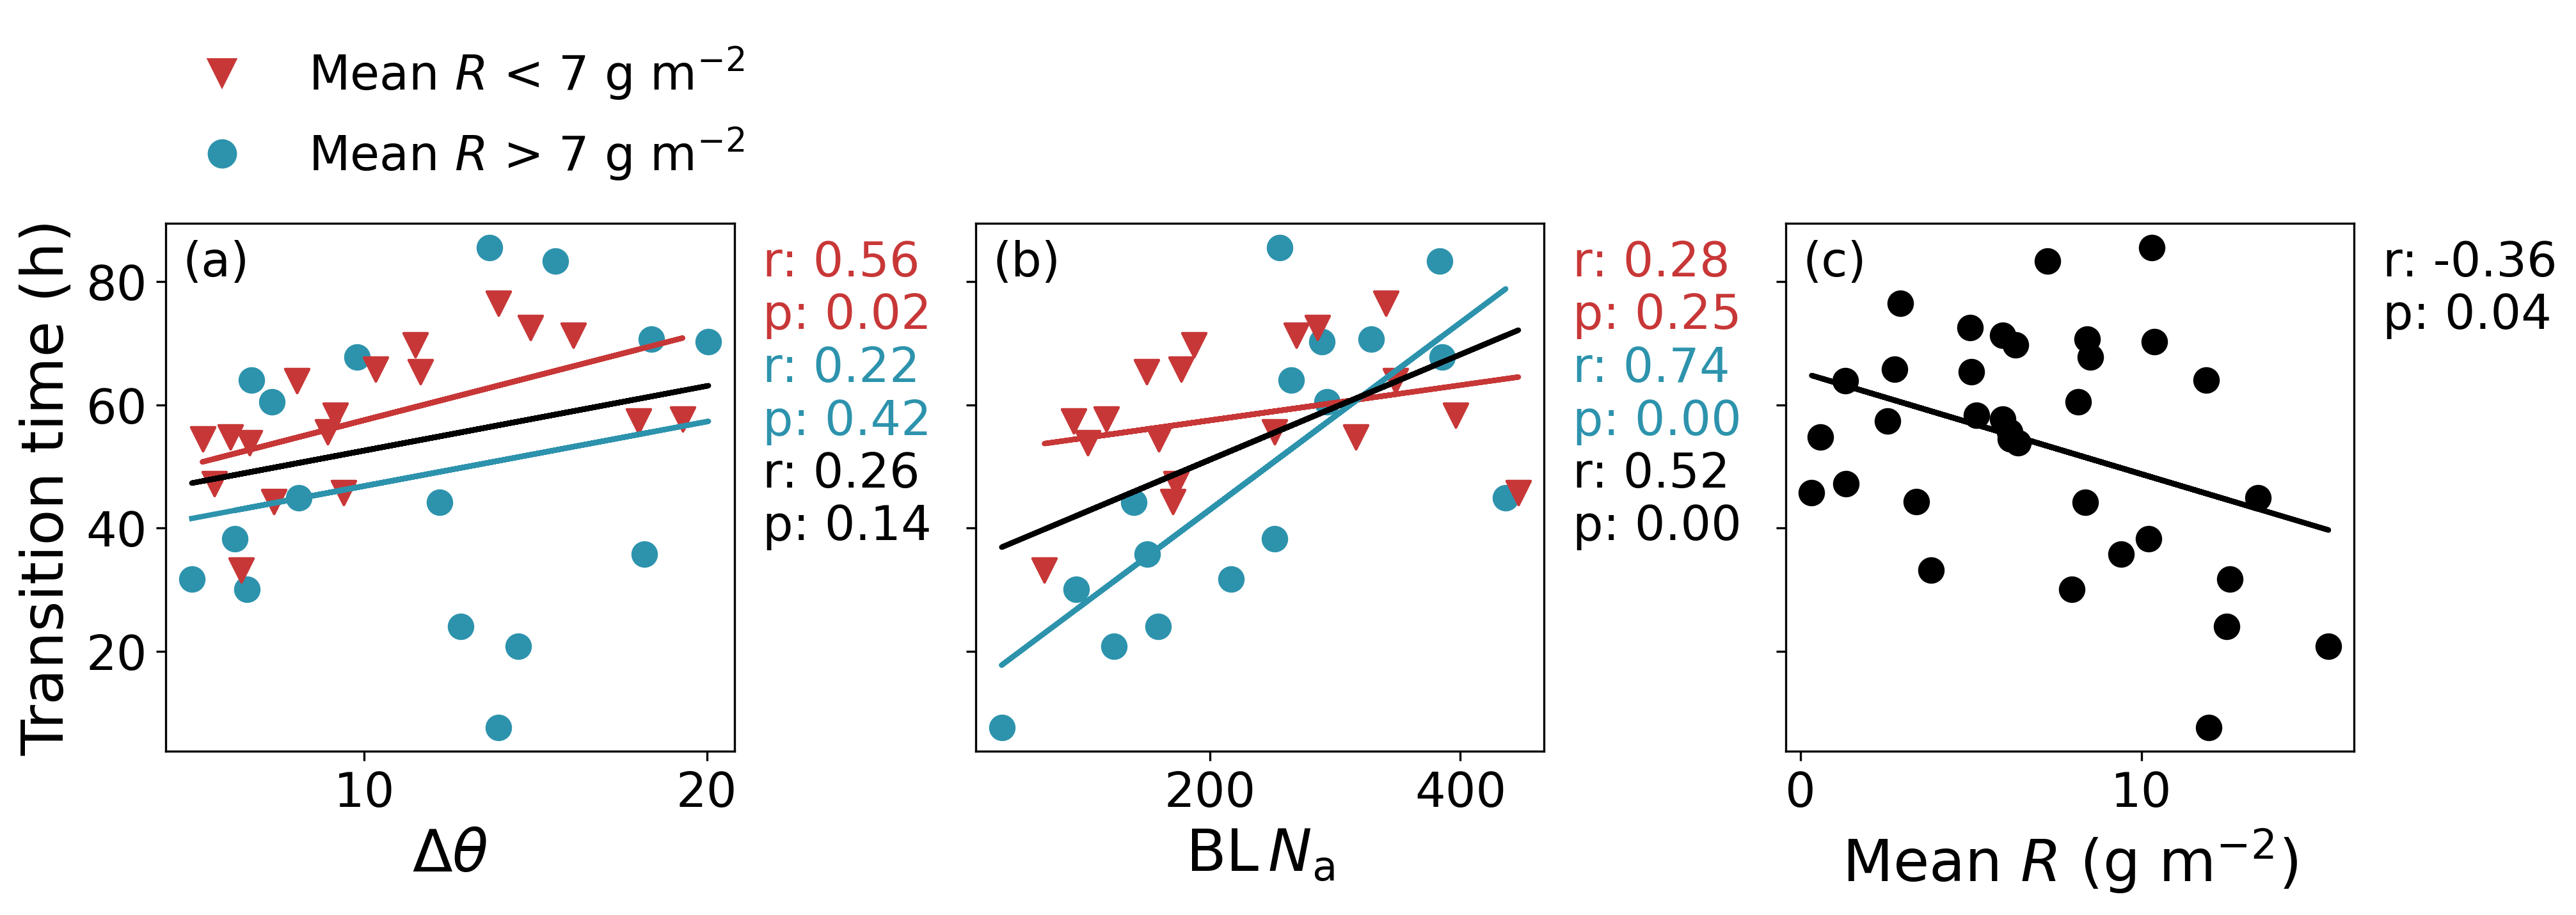

In [30]:
fig, slopes = plot_1d_keys(output_data, inputs)
plt.show()

In [ ]:
fig.savefig("figures/output_1d_rwp_split_sc_beginning_pval_mean_R_cu0pt55.png",facecolor='white',dpi=300)
fig.savefig("figures/output_1d_rwp_split_sc_beginning_pval_mean_R_cu0pt55.pdf",facecolor='white',dpi=300)

### Cu thresh = 0.47 with SST thresh = 296

In [48]:
output_data = {}
output_data["RWP mean"] = np.loadtxt("data/output_data/rwp_mean_output_047.csv", delimiter=',', skiprows=1)
output_data["Transition time"] = np.loadtxt("data/output_data/transition_time_output_047.csv", delimiter=',', skiprows=1)

inputs = np.loadtxt("data/input_data/sc_beginning_inputs_047.csv", delimiter=',', skiprows=1)
inputs[:,5] = [10**x for x in inputs[:,5]]

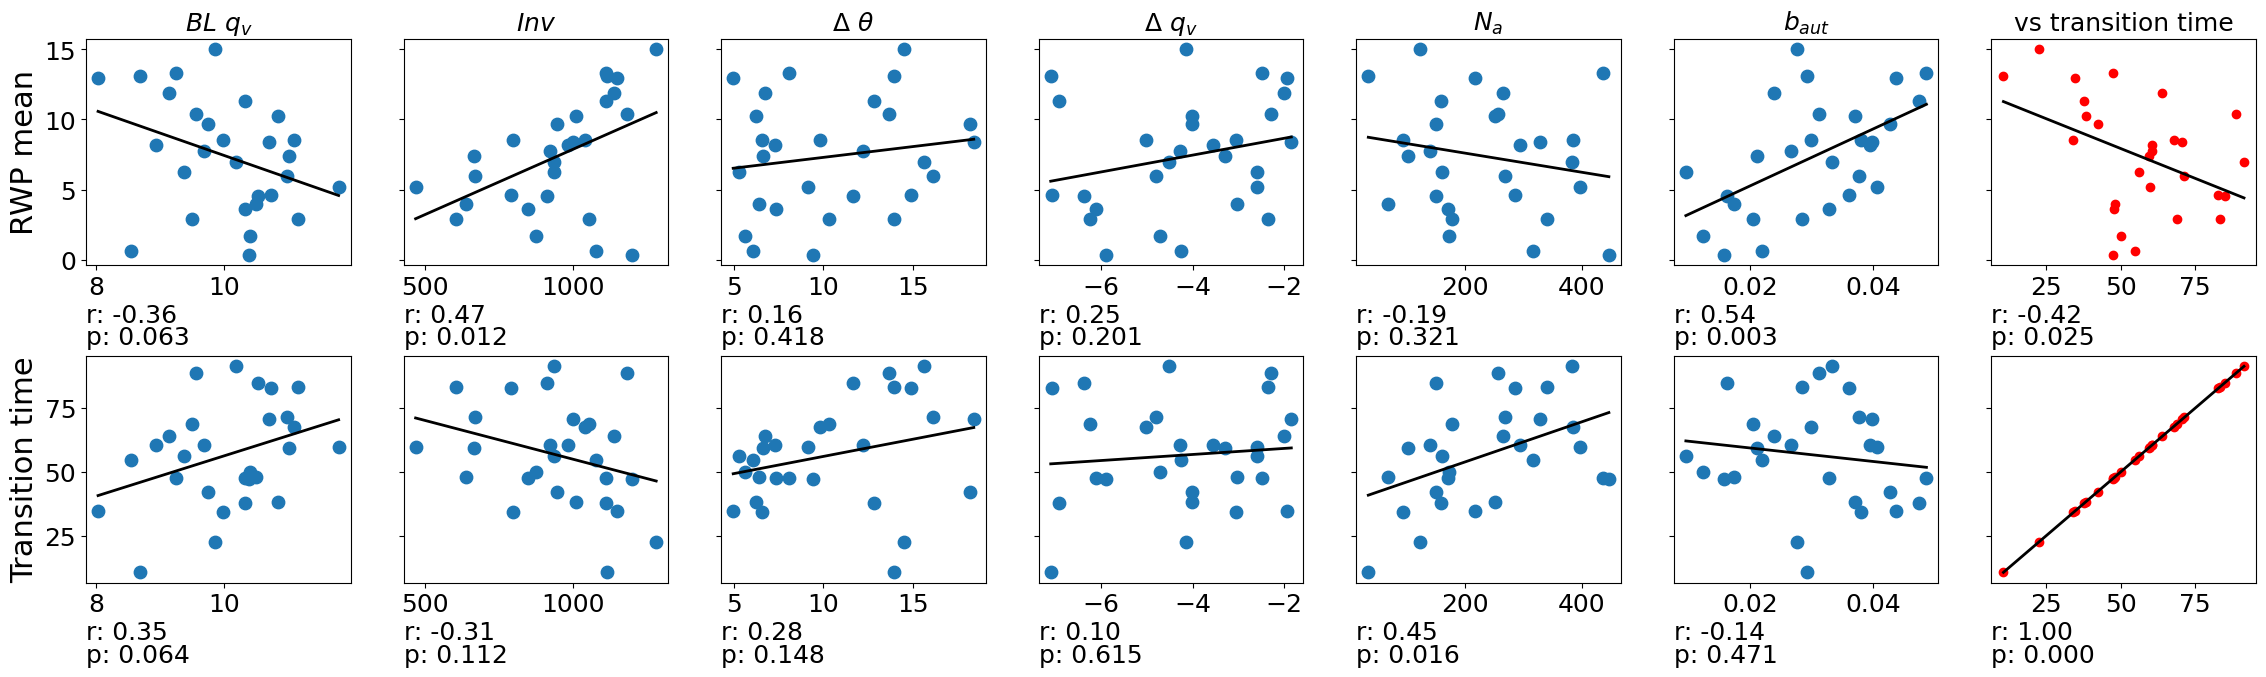

In [49]:
### Big grid of possible indicators

r = len(output_data.keys())
c = 7
fig, axes = plt.subplots(nrows=r, ncols=c, figsize=(4*c,4*r), sharey='row')
plt.subplots_adjust(hspace=0.4, bottom=0.2)

for ax_row, (name, output) in zip(axes, output_data.items()):      
    plot_output(inputs, output, ax_row, "C0", ylabel=name)
    
    ax_row[-1].scatter(output_data["Transition time"], output, c='red')
    x_data = output_data["Transition time"]
    y_data = output
    r, y_mean, x_mean, y_std, x_std = calc_r(x_data, y_data)
    m, b = calc_line(r, y_mean, x_mean, y_std, x_std)
    x_data_sorted = np.sort(x_data)
    y_pred = [(m*x+b) for x in x_data_sorted]

    corr = scipy.stats.pearsonr(x_data, y_data)  
    ax_row[-1].plot(x_data_sorted, y_pred, c='black', lw=2, label=f'r: {corr.correlation:.2f}, p: {corr.pvalue:.2f}')
    ax_row[-1].text(0, -0.25, f'r: {corr.correlation:.2f}', transform= ax_row[-1].transAxes)
    ax_row[-1].text(0, -0.35, f'p: {corr.pvalue:.3f}', transform= ax_row[-1].transAxes)

add_titles(axes)

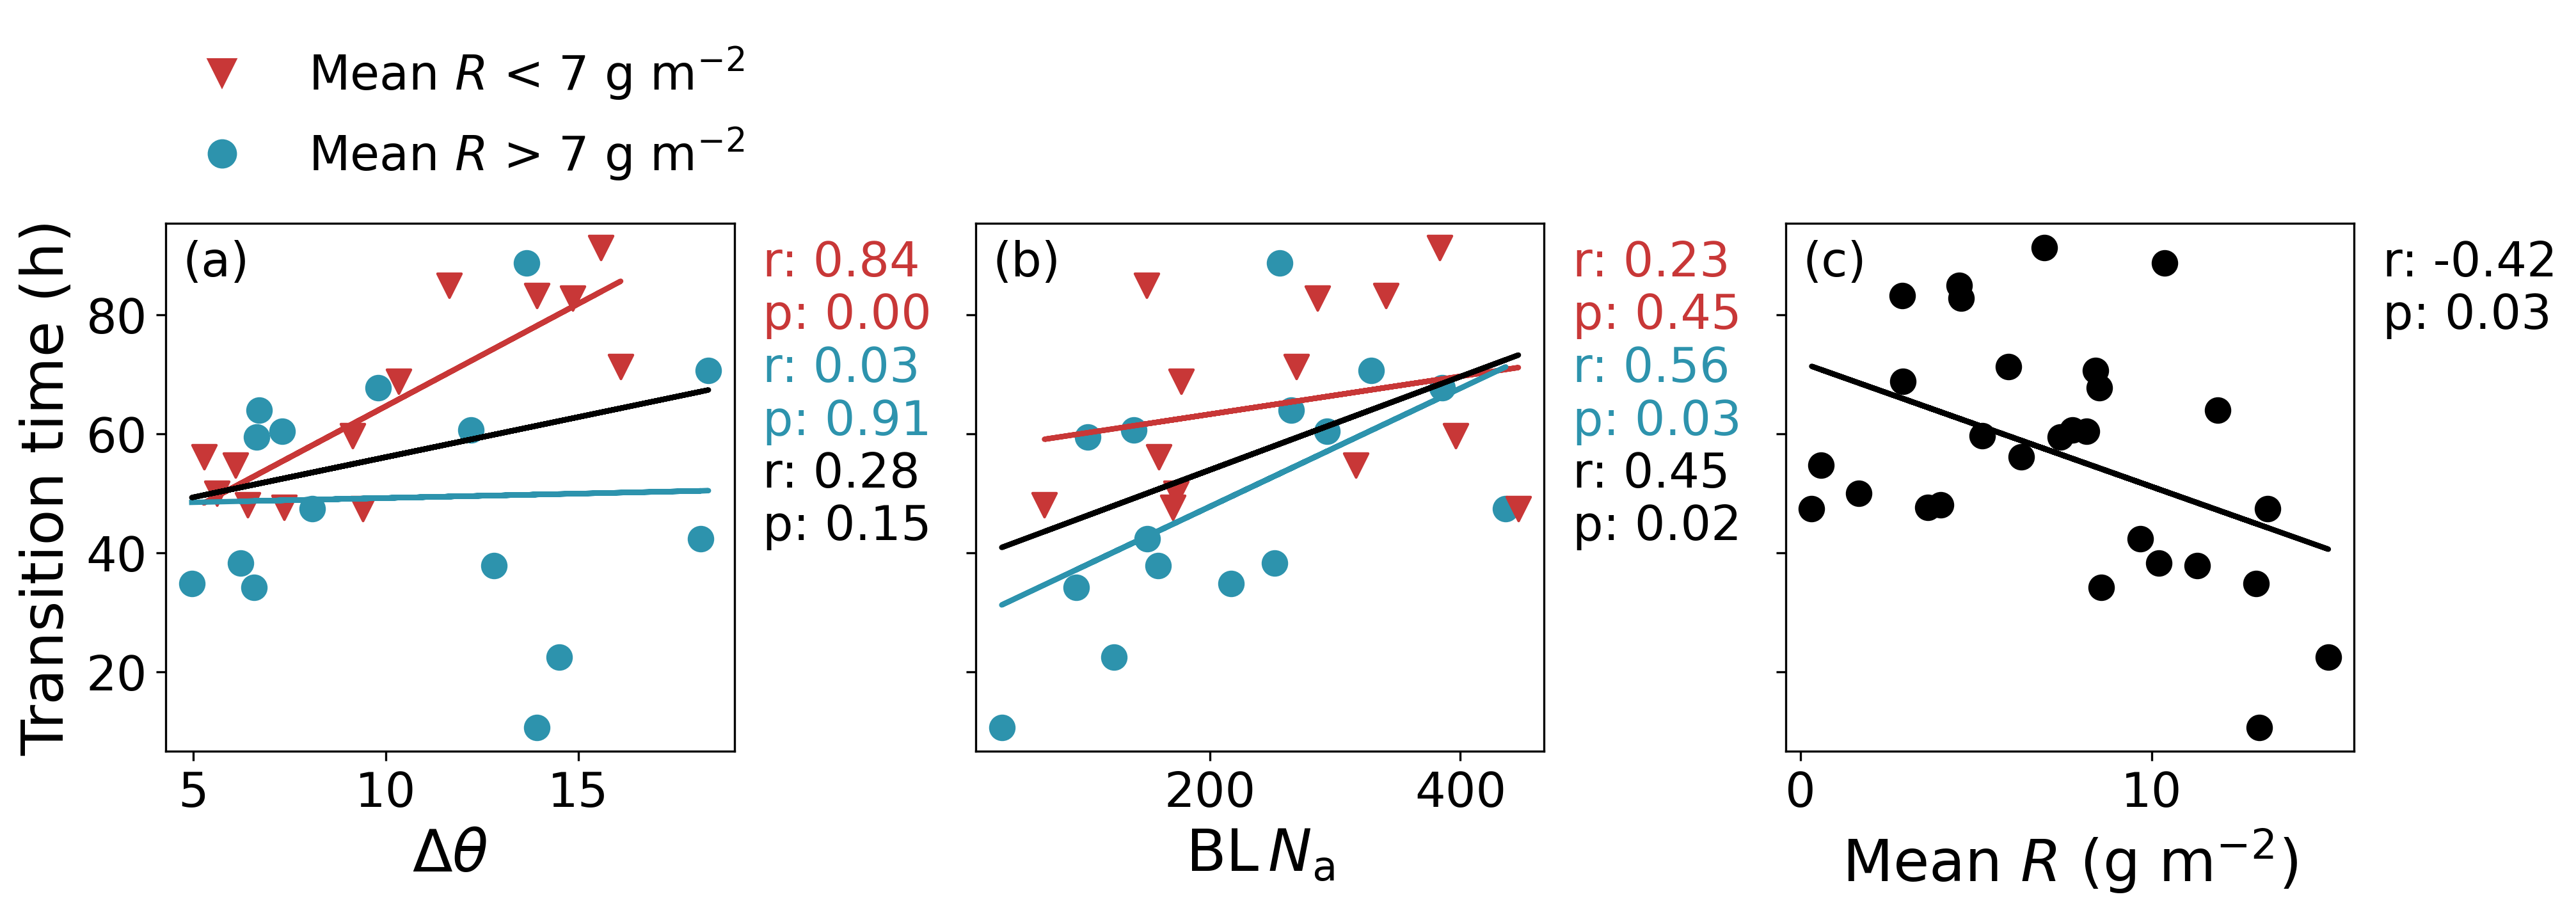

In [50]:
fig, slopes_047 = plot_1d_keys(output_data, inputs)
plt.show()

In [ ]:
fig.savefig("figures/output_1d_rwp_split_sc_beginning_pval_mean_R_cu0pt47.png",facecolor='white',dpi=300)
fig.savefig("figures/output_1d_rwp_split_sc_beginning_pval_mean_R_cu0pt47.pdf",facecolor='white',dpi=300)

### Cu thresh 0.46, SST thresh = 296 K

In [45]:
output_data = {}
output_data["RWP mean"] = np.loadtxt("data/output_data/rwp_mean_output_046.csv", delimiter=',', skiprows=1)
output_data["Transition time"] = np.loadtxt("data/output_data/transition_time_output_046.csv", delimiter=',', skiprows=1)

inputs = np.loadtxt("data/input_data/sc_beginning_inputs_046.csv", delimiter=',', skiprows=1)
inputs[:,5] = [10**x for x in inputs[:,5]]

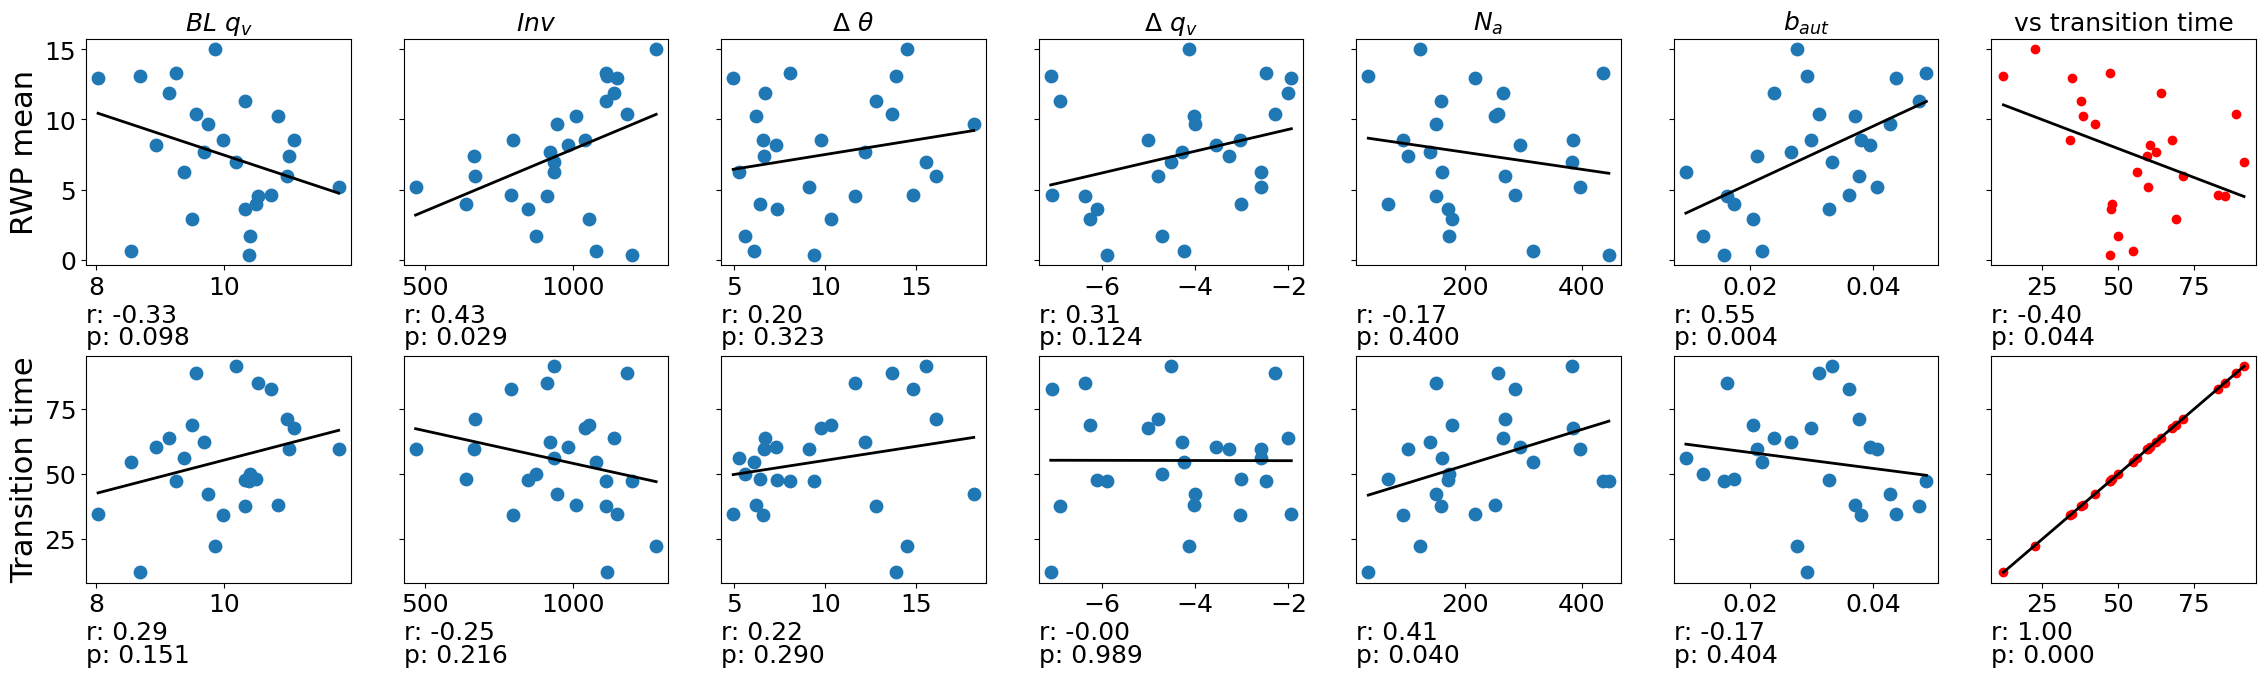

In [46]:
### Big grid of possible indicators

r = len(output_data.keys())
c = 7
fig, axes = plt.subplots(nrows=r, ncols=c, figsize=(4*c,4*r), sharey='row')
plt.subplots_adjust(hspace=0.4, bottom=0.2)

for ax_row, (name, output) in zip(axes, output_data.items()):      
    plot_output(inputs, output, ax_row, "C0", ylabel=name)
    
    ax_row[-1].scatter(output_data["Transition time"], output, c='red')
    x_data = output_data["Transition time"]
    y_data = output
    r, y_mean, x_mean, y_std, x_std = calc_r(x_data, y_data)
    m, b = calc_line(r, y_mean, x_mean, y_std, x_std)
    x_data_sorted = np.sort(x_data)
    y_pred = [(m*x+b) for x in x_data_sorted]

    corr = scipy.stats.pearsonr(x_data, y_data)  
    ax_row[-1].plot(x_data_sorted, y_pred, c='black', lw=2, label=f'r: {corr.correlation:.2f}, p: {corr.pvalue:.2f}')
    ax_row[-1].text(0, -0.25, f'r: {corr.correlation:.2f}', transform= ax_row[-1].transAxes)
    ax_row[-1].text(0, -0.35, f'p: {corr.pvalue:.3f}', transform= ax_row[-1].transAxes)

add_titles(axes)

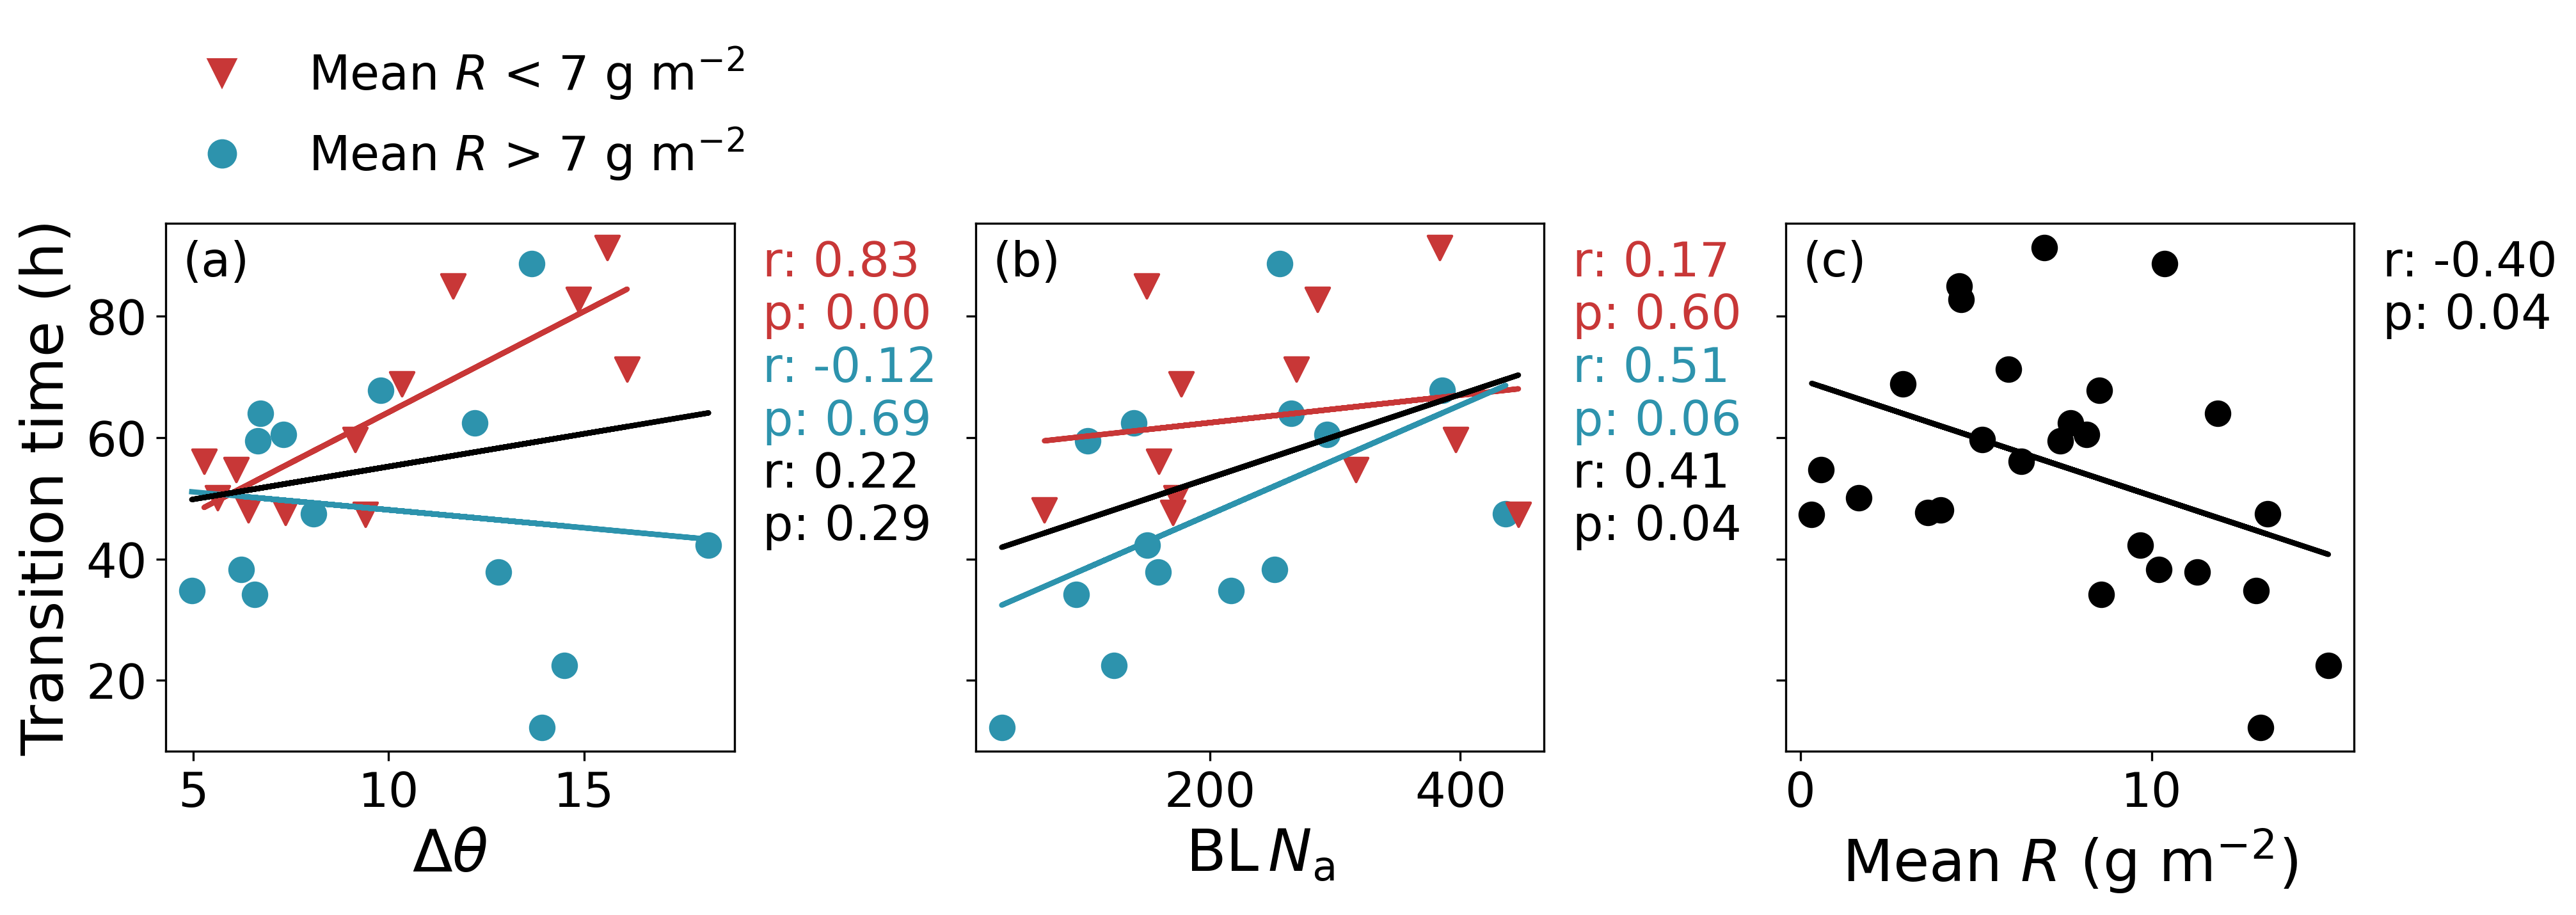

55.19387012309974
7.489222316411427


In [47]:
fig, slopes_046_296 = plot_1d_keys(output_data, inputs)
plt.show()
print(np.mean(output_data["Transition time"]))
print(np.mean(output_data["RWP mean"]))